## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics

import scipy

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

import xgboost as xgb

import mpl_scatter_density
import matplotlib.colors as colors

import csv
from scipy.spatial.distance import jensenshannon as JS

## Setting up the cluster

In [2]:
# cluster.close()

In [3]:
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

2023-06-30 14:10:20,669 - distributed.deploy.ssh - INFO - 2023-06-30 14:10:20,668 - distributed.scheduler - INFO - State start
2023-06-30 14:10:20,680 - distributed.deploy.ssh - INFO - 2023-06-30 14:10:20,679 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-30 14:10:21,663 - distributed.deploy.ssh - INFO - 2023-06-30 14:10:21,661 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:44749'
2023-06-30 14:10:21,672 - distributed.deploy.ssh - INFO - 2023-06-30 14:10:21,671 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33651'
2023-06-30 14:10:21,676 - distributed.deploy.ssh - INFO - 2023-06-30 14:10:21,675 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45163'
2023-06-30 14:10:21,681 - distributed.deploy.ssh - INFO - 2023-06-30 14:10:21,681 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43657'
2023-06-30 14:10:21,929 - distributed.deploy.ssh - INFO - 2023-06-30

In [4]:
client=Client(cluster)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+------------------+
| Package | Client | Scheduler | Workers          |
+---------+--------+-----------+------------------+
| tornado | 6.3.2  | 6.3.2     | {'6.3.2', '6.2'} |
+---------+--------+-----------+------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [5]:
client

<Client: 'tcp://10.67.22.140:8786' processes=16 threads=16, memory=31.03 GiB>

## Data

In [7]:
n_bins = 100
bhbh_train = dd.read_parquet('/home/ubuntu/train/*')

In [8]:
len(bhbh_train)

5242023

In [9]:
bhbh_train = bhbh_train[bhbh_train.No_Kick ==2]

In [10]:
len(bhbh_train)

3271433

In [11]:
bhbh_test = dd.read_parquet('/home/ubuntu/test/*')

In [12]:
len(bhbh_test)

2247825

In [13]:
bhbh_test = bhbh_test[bhbh_test.No_Kick ==2]

In [14]:
len(bhbh_test)

1403123

## Sample weigths

In [15]:
countings = bhbh_train['label'].to_frame().groupby('label').size().compute()
total_counts = countings.sum()

#Assign to a new column
def assign_weight(i):
    return np.log(total_counts/(n_bins*countings[i])+1) 

bhbh_train['weight'] = bhbh_train['label'].map(assign_weight)

## Plot of weights respect to labels

## Rename of useful columns

In [16]:
#training
weights = bhbh_train['weight']
labels = bhbh_train['label']
features = bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

#test
features_test = bhbh_test[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]
label_test = bhbh_test['label']

## Consistency of partitions

In [17]:
print('Consistency check')
print('features:', type(features), features.npartitions)

print('label', type(labels), labels.npartitions)
print('weight', type(weights), weights.npartitions)

Consistency check
features: <class 'dask.dataframe.core.DataFrame'> 1800
label <class 'dask.dataframe.core.Series'> 1800
weight <class 'dask.dataframe.core.Series'> 1800


## XGBoost

In [18]:
#parameters
max_depth = 0
learning_rate = 0.2
grow_policy = 'lossguide'
n_estimators = 5
max_leaves = 400

param = {'objective': 'multi:softprob',
         'tree_method': 'hist', 
         'n_estimators' : n_estimators, #equivalent to num_boost_round, lets keep it in params
         'grow_policy' : grow_policy, 
         'max_depth' : max_depth,
         'learning_rate' : learning_rate,
         'max_leaves' : max_leaves,
         'num_class': n_bins,
         'n_jobs' : -1,
        }

In [19]:
dtrain = xgb.dask.DaskDMatrix(client, features, label=labels, weight=weights)
# dtrain = xgb.dask.DaskDMatrix(client, features, label=labels) #test what happens without weight

In [20]:
# train XGB
bst = xgb.dask.train(client, param, dtrain, evals=[(dtrain, "train")])

## Saving and loading the trained model

In [21]:
bst['booster'].save_model(f'bst{max_depth}_{max_leaves}_NoKick2_new.json')

In [22]:
bst = xgb.Booster()
bst.load_model('bst0_400_NoKick2_new.json')

<BarContainer object of 6 artists>

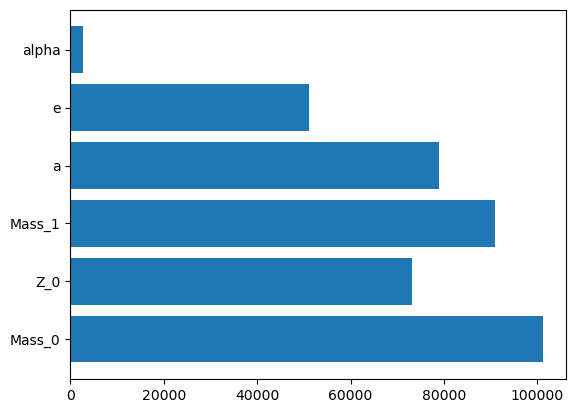

In [23]:
plt.barh(features.columns, bst.get_fscore().values())

## Prediction on test

In [24]:
## distributions of the probability of each class for each record

output_test = xgb.dask.predict(client, bst, features_test).persist() #already a dataframe

## Predicition of the label with Maximum estimation

predicted_label = output_test.idxmax(axis=1).persist()

## Computing the true labels and the predicted

Y_test = label_test.values.compute()

Y_predicted = predicted_label.values.compute()

## Scatter Plot with density

In [25]:
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap='Reds',
                                 norm=colors.LogNorm(vmin=1, vmax=1000))
    fig.colorbar(density, label='Number of points per pixel')

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


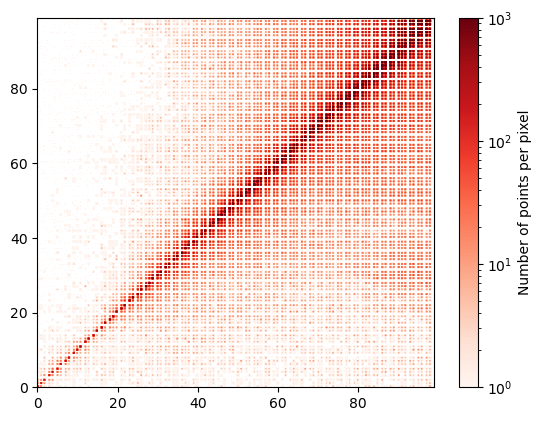

In [26]:
fig = plt.figure()
using_mpl_scatter_density(fig, Y_test, Y_predicted)
plt.show()

## Histogram of the q distribution

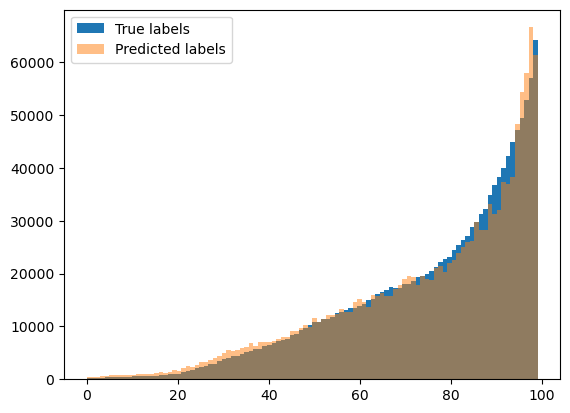

In [27]:
plt.hist(Y_test, bins=n_bins, label = 'True labels')
plt.hist(Y_predicted, bins=n_bins, alpha=0.5, label='Predicted labels')
plt.legend()

# Metrics

In [28]:
counts_test, _ = np.histogram(Y_test, density=True, bins=n_bins)
counts_predicted, _ = np.histogram(Y_predicted, density=True, bins=n_bins)

## Kulback-Leibler metrics

In [29]:
KL_div = scipy.stats.entropy(counts_predicted, counts_test)

In [30]:
KL_div

0.00686334814705663

## JS (limited between 0 and 1 when base=2)

In [31]:
JS_div = JS(counts_test, counts_predicted, base=2)

In [32]:
JS_div

0.049075011900384005

## Histogram of difference of true and prediction

In [33]:
#95% interval 
diff = (Y_predicted-Y_test)
lower=np.quantile(diff, q=0.025) 
upper= np.quantile(diff, q=0.975)
print(lower, upper)

-31.0 15.0


Text(0.5, 0, '$|y_{true}-y_{predicted}|$')

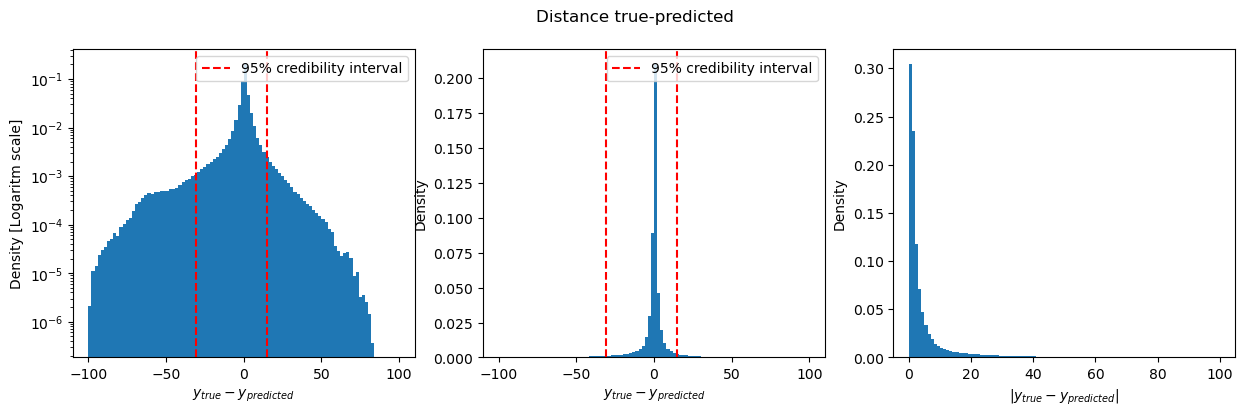

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

fig.suptitle('Distance true-predicted')
ax[0].hist(-Y_test+Y_predicted, bins=n_bins, density=True, log=True, range=(-n_bins, n_bins));
ax[0].axvline(lower,  label='95% credibility interval', color='red', linestyle='--');
ax[0].axvline(x=upper, color='red', linestyle='--');
ax[0].set_ylabel('Density [Logaritm scale]')
ax[0].set_xlabel(r'$y_{true}-y_{predicted}$')
ax[0].legend()

ax[1].hist(-Y_test+Y_predicted, bins=n_bins, density=True, range=(-n_bins, n_bins));
ax[1].axvline(x=lower, label='95% credibility interval', color='red', linestyle='--');
ax[1].axvline(x=upper, color='red', linestyle='--');
ax[1].set_ylabel('Density')
ax[1].set_xlabel(r'$y_{true}-y_{predicted}$')
ax[1].legend()

ax[2].hist(np.abs(-Y_test+Y_predicted), bins=n_bins, density=True, range=(0, n_bins));
ax[2].set_ylabel('Density')
ax[2].set_xlabel(r'$|y_{true}-y_{predicted}|$')

## Misura della accuracy

In [35]:
## Defining a prediction accurate if not further from the true of a value of threshold
def accuracy_threshold(Y_test, Y_predicted, threshold = 5):
    out=np.abs(Y_test-Y_predicted)
    mask = out < threshold
    return np.sum(mask)/len(Y_test)

In [39]:
accuracy_threshold(Y_test, Y_predicted, 15)

0.9162753372298793

In [40]:
def accuracy_exponential(Y_test, Y_predicted, threshold = 25, tau = 25):
    out = np.exp(-np.abs(Y_test-Y_predicted)/tau)
    out = out[np.abs(Y_test-Y_predicted)<threshold]
    return np.sum(out)/len(Y_test)

In [41]:
accuracy_exponential(Y_test, Y_predicted)

0.863576512638665

## Grid Search with For Loops

## Clustering of probability distribution

In [42]:
# Defininf a function to order the peaks of the probability distribution
def extract_top_values(row, n_top=3):
    row_sorted = np.sort(row)[::-1]
    return row_sorted[:n_top]

In [43]:
# Defininf a function to order the peaks of the probability distribution
def extract_id_top_values(row, n_top=3):
    idx_sorted = np.argsort(row)[::-1]
    return np.array(idx_sorted)[:n_top]

In [44]:
# applying the previous function
top_values = output_test.apply(extract_top_values, axis=1, meta=(None, 'object'))
idx_top_values = output_test.apply(extract_id_top_values, axis=1, meta=(None, 'object'))

## Creating a dataframe with all the test set information

In [45]:
top_values = top_values.compute()
top_values = pd.DataFrame(top_values.to_list(), columns = ['1', '2', '3'])

idx_top_values = idx_top_values.compute()
idx_top_values = pd.DataFrame(idx_top_values.to_list(), columns = ['1', '2', '3'])

for col in idx_top_values.columns:
    top_values[f'idx_{col}']=idx_top_values[col].values   
    
top_values['Y_predicted']=Y_predicted
top_values['Y_test']=Y_test
top_values['Delta_Y']=np.abs(Y_predicted-Y_test)

#adding feature
X_test = features_test.compute()
for col in X_test.columns:
    top_values[col]=X_test[col].values

In [46]:
top_values

1         2         3  idx_1  idx_2  idx_3  Y_predicted  \
0        0.087401  0.048021  0.043157     95     92     94           95   
1        0.165943  0.109442  0.089708     87     86     85           87   
2        0.146319  0.061782  0.060110     83     84     82           83   
3        0.199383  0.093982  0.037402     25     26     24           25   
4        0.093293  0.052993  0.040848     93     89     90           93   
...           ...       ...       ...    ...    ...    ...          ...   
1403118  0.072600  0.072452  0.054915     93     94     95           93   
1403119  0.913907  0.029013  0.010439     99     98     96           99   
1403120  0.168785  0.114420  0.094256     81     82     80           81   
1403121  0.405642  0.333352  0.011428     41     40     38           41   
1403122  0.095566  0.050481  0.043745     82     79     80           82   

         Y_test  Delta_Y   Mass_0     Z_0  Mass_1        a       e  alpha  
0            82       13   60.831  0.0004  42.856    503.0  0.0606    1.0  
1            85        2   58.943  0.0004  51.689  40200.0  0.2780    1.0  
2            83        0   68.488  0.0004  45.524  22400.0  0.1760    1.0  
3            25        0   58.378  0.0004  23.074  84100.0  0.7290    1.0  
4            91        2   33.537  0.0004  22.996     76.2  0.2720    1.0  
...         ...      ...      ...     ...     ...      ...     ...    ...  
1403118      89        4   69.694  0.0100  66.735    272.0  0.0448    3.0  
1403119      99        0   40.070  0.0100  40.036  25000.0  0.0786    3.0  
1403120      79        2   55.556  0.0100  48.744  26000.0  0.4070    3.0  
1403121      40        1  106.439  0.0100  43.318   5160.0  0.6120    3.0  
1403122      74        8   96.606  0.0100  73.664    613.0  0.0921    3.0  

[1403123 rows x 15 columns]

In [47]:
idx_diff = top_values['idx_1']-top_values['idx_2']

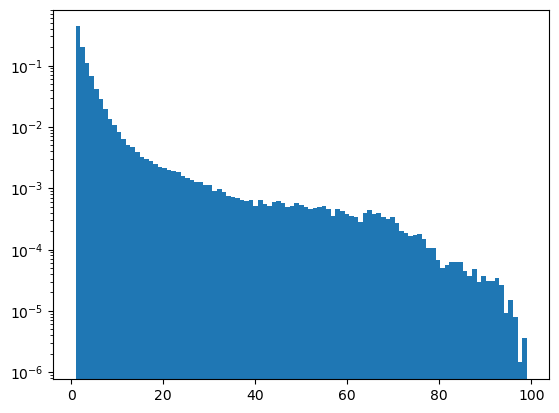

In [49]:
plt.hist(np.abs(idx_diff), bins=99, density=True, log=True);

In [54]:
lower=np.quantile(np.abs(idx_diff), q=0.8) 
lower

4.0

# Some interesting representations

## All the points

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


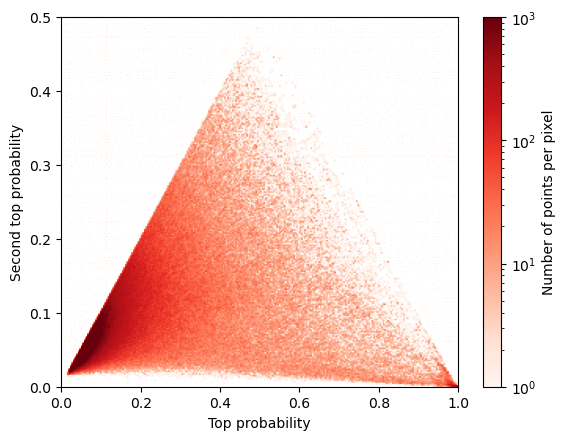

In [55]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values['1'], top_values['2'])
plt.xlabel('Top probability')
plt.ylabel('Second top probability')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

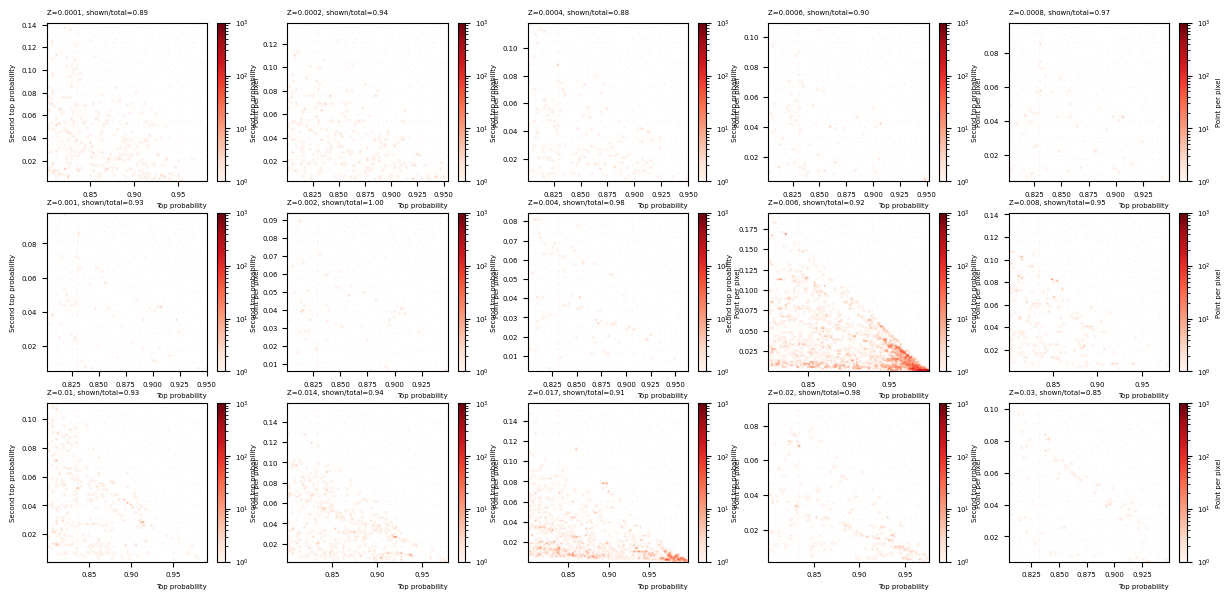

In [56]:
fontsize=5
fig = plt.figure(figsize=(15, 7))
Z=np.unique(top_values.Z_0)
for i, z in enumerate(Z):
    ax = fig.add_subplot(3, 5, i+1, projection='scatter_density')
    density = ax.scatter_density(x= top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['1'],
                       y=top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['2'],
                       cmap='Reds',
                       norm=colors.LogNorm(vmin=1, vmax=1000))
    ax.set_xlabel('Top probability', fontsize=fontsize, loc='right')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylabel('Second top probability', fontsize=fontsize)
    # ax.set_xlim(0,1)
    # ax.set_ylim(0,0.5)
    
    
    cbar = fig.colorbar(density, ax=ax)
    cbar.ax.set_ylabel(ylabel='Point per pixel', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    # cbar.set_label(fontsize=fontsize, label='Number of points per pixel')
    
    ax.set_title(f'Z={z}, shown/total={len(top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values["1"]>=0.8)])/len(top_values[(top_values.Z_0==z) & (top_values["1"]>=0.8)]):.2f}',
                 fontsize=fontsize,
                 loc='left')
    
# sns.scatterplot(data = top_values, x= '1', y='2', hue='Z_0', size=0.001)

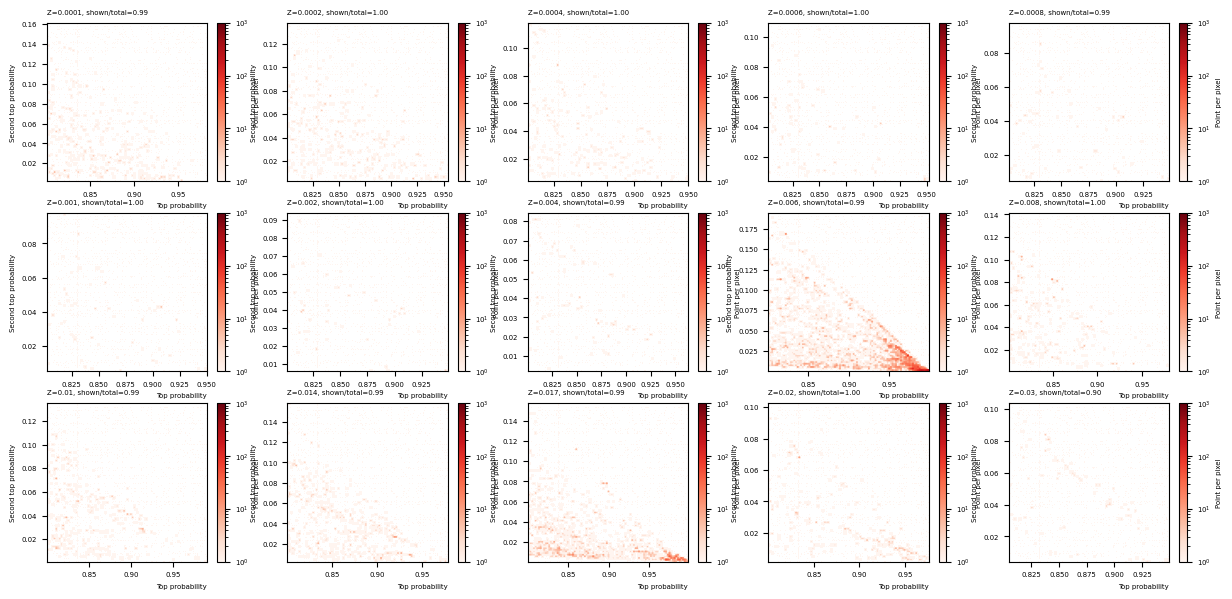

In [57]:
fontsize=5
fig = plt.figure(figsize=(15, 7))
Z=np.unique(top_values.Z_0)
for i, z in enumerate(Z):
    ax = fig.add_subplot(3, 5, i+1, projection='scatter_density')
    density = ax.scatter_density(x= top_values[(top_values.Z_0==z) & (top_values.Delta_Y <= 2) & (top_values['1']>=0.8)]['1'],
                       y=top_values[(top_values.Z_0==z) & (top_values.Delta_Y <= 2) & (top_values['1']>=0.8)]['2'],
                       cmap='Reds',
                       norm=colors.LogNorm(vmin=1, vmax=1000))
    ax.set_xlabel('Top probability', fontsize=fontsize, loc='right')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylabel('Second top probability', fontsize=fontsize)
    # ax.set_xlim(0,1)
    # ax.set_ylim(0,0.5)
    
    
    cbar = fig.colorbar(density, ax=ax)
    cbar.ax.set_ylabel(ylabel='Point per pixel', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    # cbar.set_label(fontsize=fontsize, label='Number of points per pixel')
    
    ax.set_title(f'Z={z}, shown/total={len(top_values[(top_values.Z_0==z) & (top_values.Delta_Y <= 2) & (top_values["1"]>=0.8)])/len(top_values[(top_values.Z_0==z) & (top_values["1"]>=0.8)]):.2f}',
                 fontsize=fontsize,
                 loc='left')
    
# sns.scatterplot(data = top_values, x= '1', y='2', hue='Z_0', size=0.001)

## Point correctly predicted

In [58]:
top_values_0 = top_values[top_values['Delta_Y']==0]

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


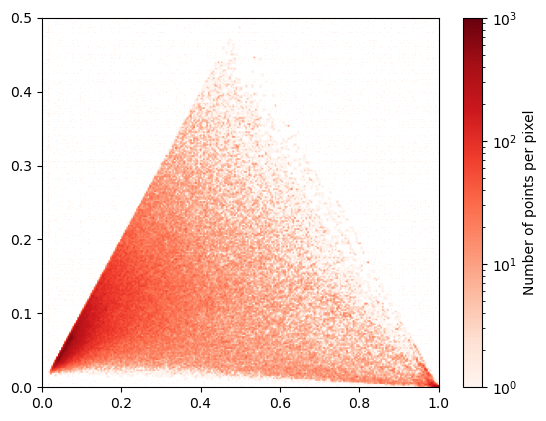

In [60]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_0['1'], top_values_0['2'])
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

### Check for the Mass dependency

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


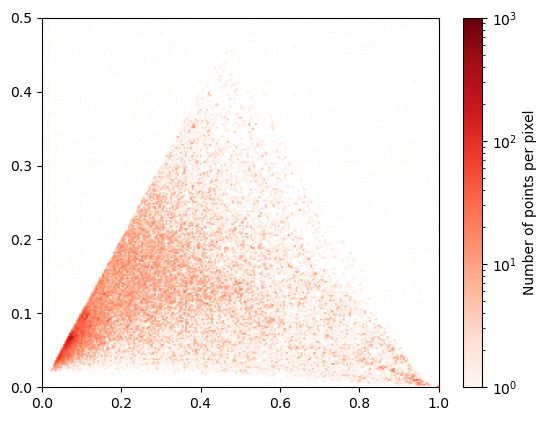

In [62]:
fig = plt.figure()
using_mpl_scatter_density(fig,
                          top_values_0[top_values_0['Mass_0']<40]['1'],
                          top_values_0[top_values_0['Mass_0']<40]['2'])
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

## Points with wrong prediction

In [68]:
top_values_15 = top_values[top_values['Delta_Y']>=6]

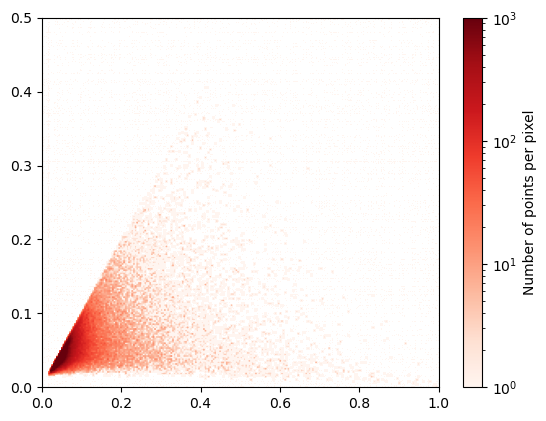

In [70]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_15['1'], top_values_15['2'])
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

### Searching for descrepancies in other features

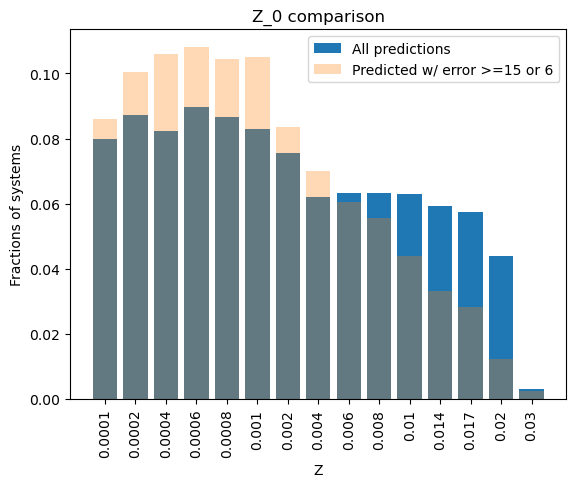

In [81]:
labels, counts = np.unique(top_values['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum(),  label='All predictions')
plt.xticks(rotation=90);

labels, counts = np.unique(top_values_15['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum(), alpha=0.3, label='Predicted w/ error >=15 or 6')
plt.xticks(rotation=90);
plt.title('Z_0 comparison');
plt.ylabel('Fractions of systems')
plt.xlabel('Z')
plt.legend()

# labels, counts = np.unique(top_values_15['Z_0'].values, return_counts=True)
# plt.bar( labels.astype(str), counts/counts.sum(), alpha=0.3)
# plt.xticks(rotation=90);
# plt.title('Z_0 comparison');

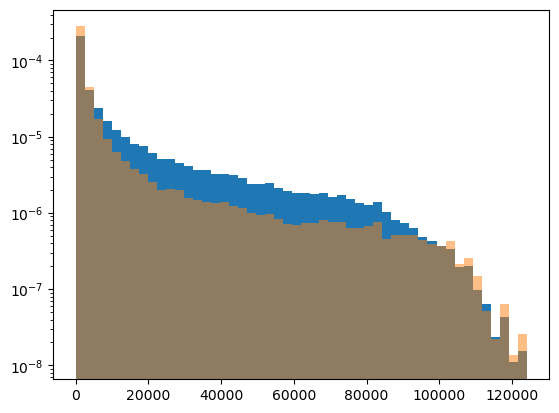

In [83]:
plt.hist(top_values['a'], density=True, bins=50, log=True);
plt.hist(top_values_15['a'], density=True, bins=50, alpha=0.5, log=True);

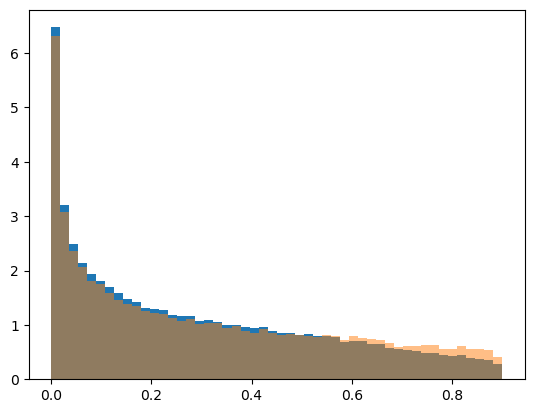

In [84]:
plt.hist(top_values['e'], density=True, bins=50, );
plt.hist(top_values_15['e'], density=True, bins=50, alpha=0.5);

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


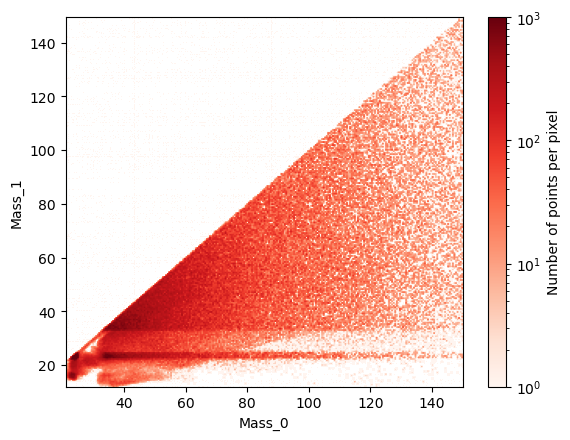

In [89]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values['Mass_0'], top_values['Mass_1'])
plt.xlabel('Mass_0')
plt.ylabel('Mass_1')
plt.show()

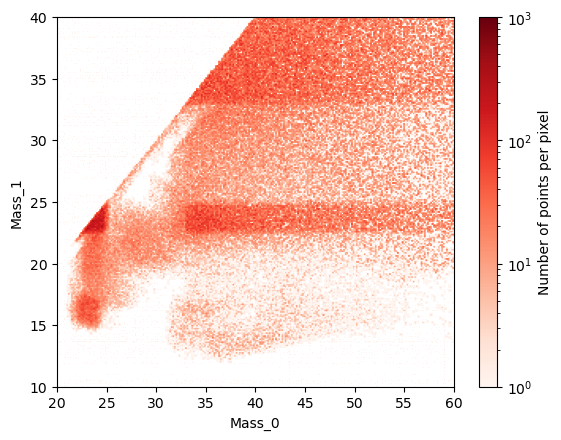

In [90]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values['Mass_0'], top_values['Mass_1'])
plt.xlim(20,60)
plt.ylim(10,40)
plt.xlabel('Mass_0')
plt.ylabel('Mass_1')
plt.show()

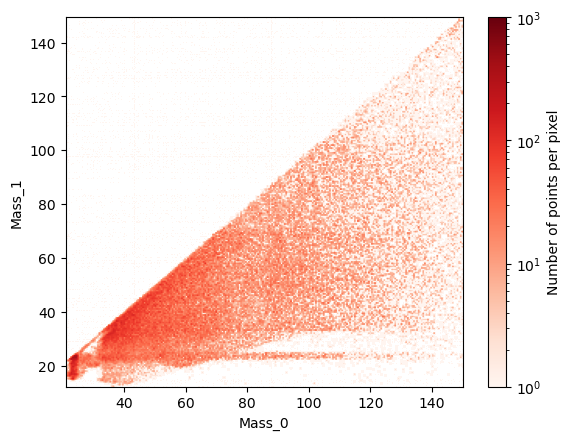

In [92]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_15['Mass_0'], top_values_15['Mass_1'])
plt.xlabel('Mass_0')
plt.ylabel('Mass_1')
plt.show()

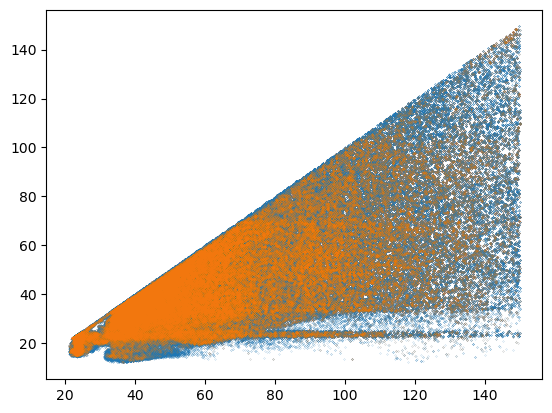

In [93]:
plt.scatter(top_values['Mass_0'], top_values['Mass_1'], s=0.01)
plt.scatter(top_values_15['Mass_0'], top_values_15['Mass_1'], alpha=0.5, s=0.01)

## Attempt of 3D plot

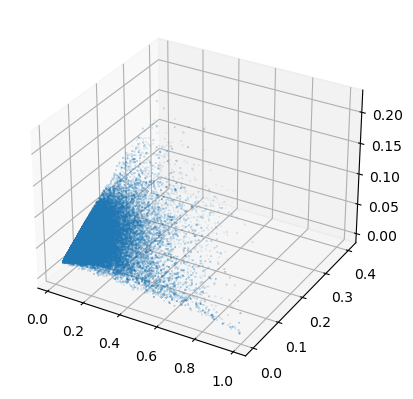

In [94]:
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(top_values_15['1'], top_values_15['2'], top_values_15['3'], s=0.01)

## Some simple statistics

In [95]:
print(f'Fraction of data in the flat region: {len(top_values[top_values["1"]<0.2])/len(top_values):.2f}')

print(f'Fraction of exactly guessed labels: {len(top_values_0)/len(top_values):.2f}')

print( f"Exactly guessed label in flat region / total points in flat region:{  len(top_values_0[top_values_0['1']<0.2])/len(top_values[top_values['1']<0.2])  :.2f}"   )

print( f"Exactly guessed label in flat region / total exactly flat labels:{  len(  top_values_0[ top_values_0[ '1' ]<0.2 ] )/len(top_values_0)  :.2f}"   )

# len(top_values[top_values['1']<0.2])/len(top_values)

Fraction of data in the flat region: 0.72
Fraction of exactly guessed labels: 0.30
Exactly guessed label in flat region / total points in flat region:0.20
Exactly guessed label in flat region / total exactly flat labels:0.47


In [ ]:
# cluster.close()

# Clustering by eye

In [96]:
one_peak = np.zeros(len(top_values))
one_peak[top_values['1']>0.8] = 1
top_values['Cluster_peak'] = one_peak.astype(int)

# Plot of cluster

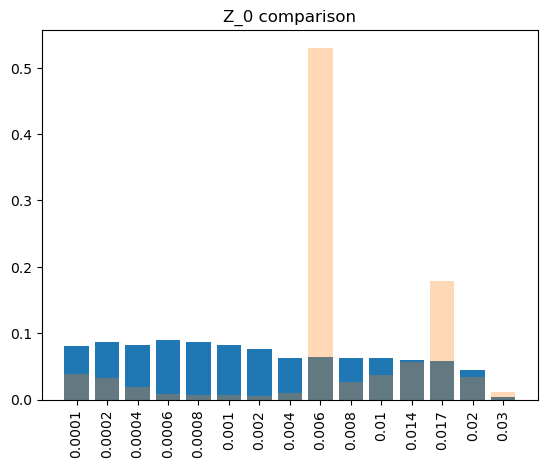

In [97]:
labels, counts = np.unique(top_values['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum())
plt.xticks(rotation=90);

labels, counts = np.unique(top_values[top_values.Cluster_peak==1]['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum(), alpha=0.3)
plt.xticks(rotation=90);
plt.title('Z_0 comparison');


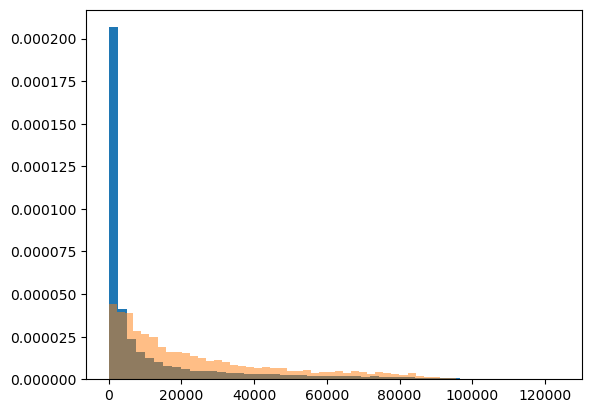

In [98]:
plt.hist(top_values['a'], density=True, bins=50);
plt.hist(top_values[top_values.Cluster_peak==1]['a'], density=True, bins=50, alpha=0.5);

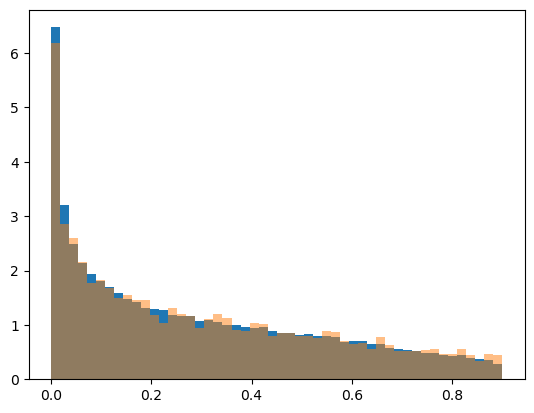

In [99]:
plt.hist(top_values['e'], density=True, bins=50, );
plt.hist(top_values[top_values.Cluster_peak==1]['e'], density=True, bins=50, alpha=0.5);

In [100]:
bhbh_test.columns

Index(['name', 'Mass_0', 'Z_0', 'SN_0', 'Mass_1', 'SN_1', 'a', 'e', 'alpha',
       'Mass_0_out', 'Mass_1_out', 'Semimajor', 'Eccentricity', 'GWtime',
       'BWorldtime', 'RLO', 'CE', 'BSN', 'No_Kick', 'tdelay', 'Mass_max_out',
       'q', 'Mass_chirp', 'label'],
      dtype='object')

In [101]:
bhbh_test[bhbh_test.Z_0==0.006].groupby("No_Kick").count().compute()

name  Mass_0    Z_0   SN_0  Mass_1   SN_1      a      e  alpha  \
No_Kick                                                                    
2.0      88916   88916  88916  88916   88916  88916  88916  88916  88916   

         Mass_0_out  ...  GWtime  BWorldtime    RLO     CE    BSN  tdelay  \
No_Kick              ...                                                    
2.0           88916  ...   88916       88916  88916  88916  88916   88916   

         Mass_max_out      q  Mass_chirp  label  
No_Kick                                          
2.0             88916  88916       88916  88916  

[1 rows x 23 columns]

In [102]:
len(bhbh_train)

3271433